keras-2.15.0 tensorflow-2.15.0

## **Introduction**

Classify on Stack Overflow into 3 categories depending on their quality.

This Case Study outlines 2 techniques to achieve the task of text classification:

1.   Training Word Embedding
2.   [Pretrained GloVe Word Embeddings](https://github.com/shraddha-an/nlp/blob/main/pretrained_glove_classification.ipynb)
3.   [fastText Classifier](https://github.com/shraddha-an/nlp/blob/main/so_fasttext.ipynb)

**Dataset**: [Stack Overflow Questions](https://www.kaggle.com/imoore/60k-stack-overflow-questions-with-quality-rate)

This is a dataset containing 60,000 Stack Overflow questions from 2016-2020. Questions are classified into three categories:

HQ: High-quality posts without a single edit.  
LQ_EDIT: Low-quality posts with a negative score, and multiple community edits. However, they still remain open after those changes.  
LQ_CLOSE: Low-quality posts that were closed by the community without a single edit.


## 1) **Data Preparation**

In [1]:
# Importing libraries
# Data Manipulation/ Handling
import pandas as pd, numpy as np

# Visualization
import seaborn as sb, matplotlib.pyplot as plt

# NLP libraries
import re
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess

In [2]:
# Importing training & testing datasets
dataset = pd.read_csv('data/train.csv')[['Body', 'Y']].rename(columns = {'Body': 'question', 'Y': 'category'})
ds = pd.read_csv('data/valid.csv')[['Body', 'Y']].rename(columns = {'Body': 'question', 'Y': 'category'})

## **2) Preprocessing**

In [3]:
# Removing symbols, stopwords, punctuation
stop_words = set(stopwords.words('english'))

symbols = re.compile(pattern = '[/<>(){}\[\]\|@,;]')
tags = ['href', 'http', 'https', 'www']

def text_clean(s: str) -> str:
    """
    Removes unwanted symbols, punctuation and stop words from a given string.
    """
    s = symbols.sub(' ', s)
    for i in tags:
        s = s.replace(i, ' ')
    cleaned_text = ' '.join(word for word in simple_preprocess(s, deacc = True) if not word in stop_words)
    return cleaned_text

# Applying the function on the questions column
dataset.iloc[:, 0] = dataset.iloc[:, 0].apply(text_clean)
ds.iloc[:, 0] = ds.iloc[:, 0].apply(text_clean)

# Train & Test subsets
X_train, y_train = dataset.iloc[:, 0].values, dataset.iloc[:, 1].values.reshape(-1, 1)
X_test, y_test = ds.iloc[:, 0].values, ds.iloc[:, 1].values.reshape(-1, 1)

## **3) Categorical Encoding**

In [4]:
# One Hot Encoding the Categories Column
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(transformers = [('one_hot_encoder', ohe(categories = 'auto'), [0])],
                       remainder = 'passthrough')

y_train = ct.fit_transform(y_train)
y_test = ct.transform(y_test)

In [5]:
y_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## **4) Tokenization**

There are some key parameters that have to be decided upon before training our network. These include the size of the vocabulary or the number of unique words in our corpus and the dimension of our embedded vectors.

In [6]:
# Vectorizing our text corpus of questions
# Setting some paramters
vocab_size = 2100
sequence_length = 300

# Tokenization with keras
from keras.preprocessing.text import Tokenizer

tk = Tokenizer(num_words = vocab_size)
tk.fit_on_texts(X_train)

X_train = tk.texts_to_sequences(X_train)  # convert sentences into a list of numbers representing words
X_test = tk.texts_to_sequences(X_test)

# Padding all questions with zeros
from keras.preprocessing.sequence import pad_sequences

X_train_seq = pad_sequences(X_train, maxlen = sequence_length, padding = 'post')  # set to he length of the longest question in the dataset.
X_test_seq = pad_sequences(X_test, maxlen = sequence_length, padding = 'post')

In [7]:
X_train_seq

array([[ 327,  767,  293, ...,    0,    0,    0],
       [  20,  248,   15, ...,    0,    0,    0],
       [1283, 1091,   29, ...,  232,    1,    4],
       ...,
       [ 386,   20,  761, ...,    0,    0,    0],
       [ 363,   22,  604, ...,    0,    0,    0],
       [  10,  812,  572, ...,    0,    0,    0]])

## **5) Embedding Model**


Build and train our model which consists of 2 main layers, an Embedding layer that will learn from our training documents prepared above and a Dense output layer to implement the classification task.

In [8]:
# Building & Training the model
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 5 , input_length = sequence_length))
model.add(Flatten())
model.add(Dense(units = 3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam', # rmsprop
              metrics = ['accuracy'])

model.summary()

history = model.fit(X_train_seq, y_train, epochs = 20, batch_size = 512, verbose = 1)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 5)            10500     
                                                                 
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense (Dense)               (None, 3)                 4503      
                                                                 
Total params: 15003 (58.61 KB)
Trainable params: 15003 (58.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20


88/88 [==============================] - 2s 9ms/step - loss: 1.0183 - accuracy: 0.4725
Epoch 2/20
88/88 [==============================] - 1s 9ms/step - loss: 0.7616 - accuracy: 0.6788
Epoch 3/20
88/88 [==============================] - 1s 9ms/step - loss: 0.6149 - acc

## **6) Evaluating Performance**

In [9]:
# Evaluating model performance on test set
loss, accuracy = model.evaluate(X_test_seq, y_test, verbose = 1)
print("\nAccuracy: {}\nLoss: {}".format(accuracy, loss))

# Save the model
#model.save('mdl_80.h5')

# Loading a saved model
#from keras.models import load_model
#model = load_model('mdl_80.h5')

469/469 [==============================] - 1s 1ms/step - loss: 0.4618 - accuracy: 0.8048

Accuracy: 0.8047999739646912
Loss: 0.4617760181427002


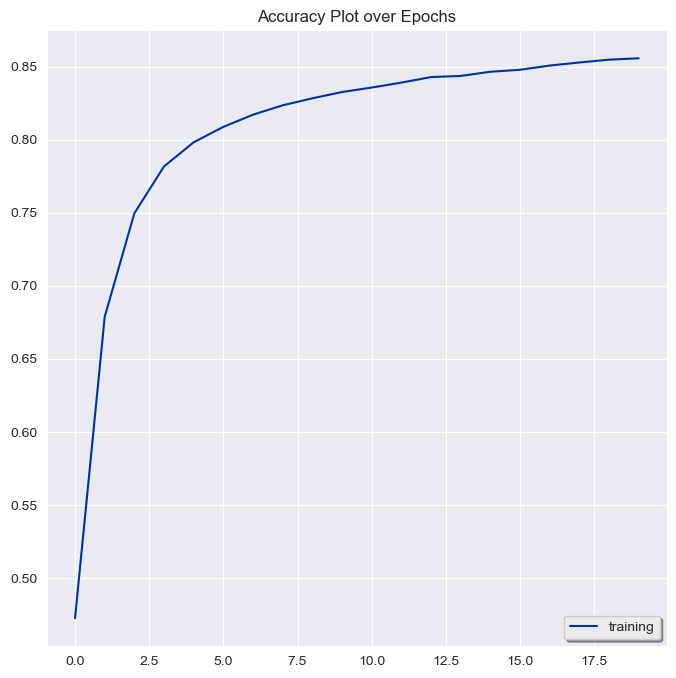

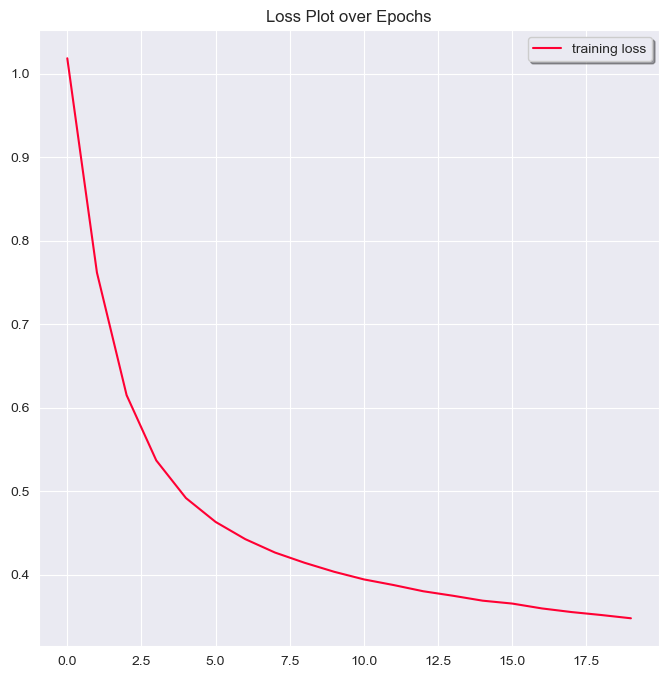

In [10]:
# Plotting Accuracy & Loss over epochs
sb.set_style('darkgrid')

# 1) Accuracy
plt.figure(figsize = (8, 8))
plt.plot(history.history['accuracy'], label = 'training', color = '#003399')
plt.legend(shadow = True, loc = 'lower right')
plt.title('Accuracy Plot over Epochs')
plt.show()

# 2) Loss
plt.figure(figsize = (8, 8))
plt.plot(history.history['loss'], label = 'training loss', color = '#FF0033')
plt.legend(shadow = True, loc = 'upper right')
plt.title('Loss Plot over Epochs')
plt.show()